## Fitting method

## Control Variables : <font color = 'sky blue'> $n_e,n_+,n_-,T_e, T_+,T_-, m_+,m_-$ </font>
<font size="2">
    [1] <a href="https://sci-hub.st/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.st/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br><br>
    
Number of control variables can be reduced by set $m_+,m_-$ and $n_+ =n_e+n_-$ <br>
Ion composition setup : $SF_5^+,SF_5^-$ and m=127AMU<br>
Fitting error within 5%

In [20]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import ldf
from scipy.special import erfc
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

## Model Setup

In [62]:
#######################
## Physical Constant ##
#######################
e = 1.6e-19 # electron charge [C]
epsilon_0 = 8.854e-12 # permittivity of vacuum [F/m]
kB = 1.38e-23 #Bolzmann const [kg m2/s2/K]
Mp = 32*1.67e-27 # mass of positive ion [kg] SF5+
Mn = 32*1.67e-27 # mass of negative ion [kg] SF5-
Me = 9.11e-31 # mass of electron [kg]
hr = 0.6 # h-factor
rp = 150e-6 # probe radius [m]
lp = 10e-3 # probe length [m]
Ap = 2*np.pi*lp*rp + 2*np.pi*rp**2 # probe surface area[m2]

## 계산될 Parameter

In [63]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [64]:
def solve_as(Te, Tm, a_0):
    def eqn21(a_s):
        return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+Te/Tm*a_s)*(1-Te/Tm))
    a_s = max(fsolve(eqn21,np.logspace(-4,2,7)))
    return a_s

def cylindrical_sheath(uB, J, V_probe):
    R = 20*rp
    r_list = np.linspace(R, rp, 20000)
    def fun(y, r):
        return [R*J/(r*epsilon_0*y[1]) - y[0]/r, e*y[0]/(Mp*y[1])]   # y는 E, u 로 이루어져있음

    sol = odeint(fun, y0=[0, uB], t=r_list)  # Sheath edge로 추정되는 부분에서 적분 시작
    u = sol[:, 1]
    
    r_sh = r_list[find_nearest(u, np.sqrt(2*e*V_probe/(Mp)))]
    return r_sh

def Seff(V, n_e, n_m, Te, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_as(Te, Tm, n_m/n_e)
    uBp = np.sqrt(e*Te/Mp)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    J = hr*n_p*e*uBp
    r_sh = cylindrical_sheath(uBp, J, abs(V-Vp))
    #r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/Me)*(abs(V-Vp))**1.5/J)
    return 2*np.pi*r_sh*lp + 2*np.pi*r_sh**2
    #return Ap

#### 위 두개는 iterative class에서 상속받아 쓸거임

def I_p(V, n_e, n_m, Te, Tp, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_as(Te, Tm, n_m/n_e)
    uBp = np.sqrt(e*Te/Mp)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))

    if Vp > V:
        I_Vp = hr*n_p*e*uBp*Seff(Vp, n_e, n_m, Te, Tm, Vp)
        I = 2*I_Vp - hr*n_p*e*uBp*Seff(V, n_e, n_m, Te, Tm, Vp)
    else:
        I_Vp = hr*n_p*e*uBp*Seff(V, n_e, n_m, Te, Tm, Vp)
        I = I_Vp*np.exp(-(V-Vp)/Tp)
    return I
    
def I_e(V, n_e, Te, Vp):
    ve = np.sqrt(8*e*Te/np.pi/Me)
    
    if Vp > V:
        I = e*Ap*n_e*ve/4*np.exp(-(Vp - V)/Te)
    else:
        I = e*Ap*n_e*ve/2*(2*np.sqrt((V-Vp)/Te/np.pi)+1/2*np.exp((V-Vp)/Te)*erfc((V-Vp)/Te))
    return I
    
def I_n(V, n_e, n_m, Te, Tm, Vp):
    uBn = np.sqrt(e*Tm/Mn)

    if Vp > V:
        I_Vp = hr*n_m*e*uBn*Seff(V, n_e, n_m, Te, Tm, Vp) # Seff(V) function 만들기
        I = I_Vp*np.exp(-(Vp - V)/Tm)
        #print('I: {:.4e}'.format(I))
    else:
        I_Vp = hr*n_m*e*uBn*Seff(Vp, n_e, n_m, Te, Tm, Vp)
        I = 2*I_Vp - hr*n_m*e*uBn*Seff(V, n_e, n_m, Te, Tm, Vp)
        #print('I: {:.4e}'.format(I))
    return I

def total_current(V_input, ne, nm, Te, Tp, Tm):
    I_list = []
    for V in V_input:
        I_list.append(-I_p(V, ne, nm, Te, Tp, Tm, Vp) + I_e(V, ne, Te, Vp) + I_n(V, ne, nm, Te, Tm, Vp))
    return np.array(I_list)

In [65]:
data_iter, data_fit = [], []

workDir = './Test_Various Conditions_O2/'
x_type = 'Distance'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)


    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return=True)

./Test_Various Conditions_O2/3.ldf


In [81]:
Vp = -3.4
ne = 6e14
nm = 1.2e14
Te = 1.28
Tp = 0.2
Tm = 0.2

In [82]:
V_list = np.linspace(Vp-20,Vp+20,200)
I_list, I_p_list, I_e_list, I_n_list = [], [], [], []

for V in V_list:
    I_p_list.append(-I_p(V, ne, nm, Te, Tp, Tm, Vp))
    I_e_list.append(I_e(V, ne, Te, Vp))
    I_n_list.append(I_n(V, ne, nm, Te, Tm, Vp))
    I_list.append(-I_p(V, ne, nm, Te, Tp, Tm, Vp) + I_e(V, ne, Te, Vp) + I_n(V, ne, nm, Te, Tm, Vp))

C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


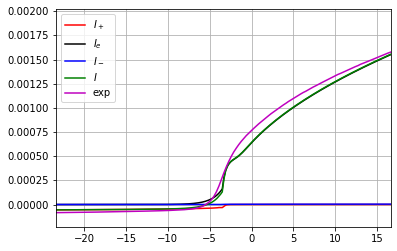

In [83]:
plt.figure(figsize=(6, 4))
plt.plot(V_list, I_p_list, c='r')
plt.plot(V_list, I_e_list, c='k')
plt.plot(V_list, I_n_list, c='b')
plt.plot(V_list, I_list, c='g')
plt.plot(np.array(IV['V']),np.array(IV['I']), c='m')
plt.grid(1)
plt.xlim(Vp-20, Vp+20)
plt.legend(['$I_+$', '$I_e$', '$I_-$', '$I$', 'exp'])

In [85]:
V_list = np.array(IV['V'])
I_list = np.array(IV['I'])

I_list = I_list[V_list < (Vp + 20)]
V_list = V_list[V_list < (Vp + 20)]

I_list = I_list[V_list > (Vp - 20)]
V_list = V_list[V_list > (Vp - 20)]

#popt, pcov = curve_fit(total_current, V_list, I_list, p0=(1.5e13, 1e15, 2, 0.2, 0.2, 6), bounds=([-np.inf, -np.inf, 0, 0, 0, -100], [np.inf, np.inf, 10, 0.5, 0.5, 100]), method='trf')
popt, pcov = curve_fit(total_current, V_list, I_list, p0=(6e14, 1.2e14, 1.28, 0.2, 0.2))

C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt


In [90]:
ne1, nm1, Te1, Tp1, Tm1 = popt
print("{:.2e} {:.2e} {:.2e} {:.2e} {:.2e} ".format(ne1, nm1, Te1, Tp1, Tm1))
print("{:.2e} {:.2e} {:.2e} {:.2e} {:.2e} ".format(ne, nm, Te, Tp, Tm))
I_fitting_list = total_current(V_list, ne1, nm1, Te1, Tp1, Tm1)
error = np.average(abs((I_list - I_fitting_list)/I_list))*100

6.07e+14 1.92e+15 2.29e+00 1.45e+00 2.01e-01 
6.00e+14 1.20e+14 1.28e+00 2.00e-01 2.00e-01 


C:\Users\GUNU\anaconda3\envs\py_36\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


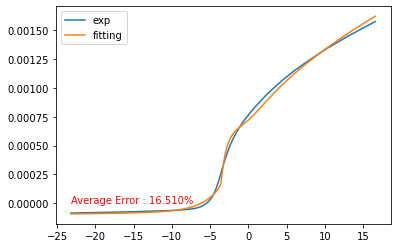

In [91]:
plt.plot(V_list, I_list)
plt.plot(V_list, I_fitting_list)
plt.legend(['exp', 'fitting'])
plt.text(V_list[0],0, 'Average Error : {:.3f}%'.format(error), fontsize=10, color='red')
plt.show()